See emails from:

Jim 15/06/2016 14:19

Cinzia 22/03/2016 07:47

Roberto 14/06/2016 15:17

In [72]:
%run _standard_imports.ipynb
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')


python 3.4.3 |Anaconda 2.2.0 (64-bit)| (default, Mar  6 2015, 12:03:53) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.9.2
scipy 0.15.1
pandas 0.15.2
numexpr 2.3.1
pysam 0.8.3
pysamstats 0.23
petl 1.0.11
petlx 1.0.3
vcf 0.6.7
vcfnp 2.3.0.dev0
h5py 2.4.0
tables 3.1.1


In [8]:
output_dir = '/nfs/team112_internal/rp7/data/Pf/hrp'
!mkdir -p {output_dir}/fofns
!mkdir -p {output_dir}/metadata
!mkdir -p {output_dir}/scripts

cinzia_metadata_fn = '%s/metadata/PF_metadata_base.csv' % output_dir # From Cinzia 22/03/2016 07:47
v4_metadata_fn = '%s/metadata/PGV4_mk5.xlsx' % output_dir # From Roberto 14/06/2016 15:17
v5_metadata_fn = '%s/metadata/v5.xlsx' % output_dir # From Roberto 14/06/2016 15:17
iso_country_code_fn = '%s/metadata/country-codes.csv' % output_dir # https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv
regions_in_dataset_fn = '%s/metadata/regions_in_dataset.xlsx' % output_dir
sub_contintent_fn = '%s/metadata/region_sub_continents.xlsx' % output_dir
manifest_fn = '%s/metadata/hrp_manifest_20160621.txt' % output_dir
# jim_manifest_fn = '%s/metadata/manifest_for_jim_20160620.txt' % output_dir
lookseq_fn = '%s/metadata/lookseq.txt' % output_dir
vrpipe_metadata_script_fn = "%s/scripts/vrpipe_metadata.sh" % output_dir
vrpipe_metadata_fn = "%s/metadata/vrpipe_metadata_20160621.txt" % output_dir

lab_studies = list(range(1032, 1044, 1)) + [1104, 1133, 1150, 1153]

# cinzia_extra_metadata_fn = '/nfs/team112_internal/rp7/data/Pf/4_0/meta/PF_extrametadata.csv' # From Cinzia 22/03/2016 08:22


In [3]:
fofns = collections.OrderedDict()

fofns['pf_community_5_0'] = '/nfs/team112_internal/production/release_build/Pf/5_0_release_packages/pf_50_freeze_manifest_nolab_olivo.tab'
fofns['pf_community_5_1'] = '/nfs/team112_internal/production_files/Pf/5_1/pf_51_samplebam_cleaned.fofn'
fofns['pf3k_pilot_5_0_broad'] = '/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/pf3k_metadata.tab'
fofns['pdna'] = '/nfs/team112_internal/production_files/Pf/PDNA/pf_pdna_new_samplebam.fofn'
fofns['conway'] = '/nfs/team112_internal/production_files/Pf/1147_Conway/pf_conway_metadata.fofn'
fofns['trac'] = '%s/fofns/olivo_TRAC.fofn' % output_dir
fofns['fanello'] = '%s/fofns/olivo_fanello.fofn' % output_dir

In [4]:
import glob

bam_dirs = collections.OrderedDict()
bam_dirs['trac'] = '/nfs/team112_internal/production_files/Pf/olivo_TRAC/remapped'
bam_dirs['fanello'] = '/nfs/team112_internal/production_files/Pf/olivo_fanello'

for bam_dir in bam_dirs:
    !rm {fofns[bam_dir]}
    with open(fofns[bam_dir], "a") as fofn:
# glob.glob('%s/*.bam' % fofns['trac'])
        print("path\tsample", file=fofn)
        for x in glob.glob('%s/*.bam' % bam_dirs[bam_dir]):
            print("%s\t%s" % (x, os.path.basename(x).replace('_', '-').replace('.bam', '')), file=fofn)
# [os.path.basename(x) for x in glob.glob('%s/*.bam' % fofns['trac'])]


In [41]:
for i, fofn in enumerate(fofns):
    if i == 0:
        tbl_all_bams = (
            etl.fromtsv(fofns[fofn])
            .cut(['path', 'sample', 'bases_of_5X_coverage', 'mean_coverage'])
            .rename('bases_of_5X_coverage', 'orig_bases_of_5X_coverage')
            .rename('mean_coverage', 'orig_mean_coverage')
            .addfield('dataset', fofn)
        )
    else:
        if fofn == 'pf3k_pilot_5_0_broad':
            tbl_all_bams = (
                tbl_all_bams
                .cat(
                    etl.fromtsv(fofns[fofn])
                    .selecteq('study', 'Pf3k_Senegal')
                    .cut(['path', 'sample', 'bases_of_5X_coverage', 'mean_coverage'])
                    .rename('bases_of_5X_coverage', 'orig_bases_of_5X_coverage')
                    .rename('mean_coverage', 'orig_mean_coverage')
                    .addfield('dataset', fofn)
                )
            )
        elif fofn in ['pf_community_5_0', 'conway']:
            tbl_all_bams = (
                tbl_all_bams
                .cat(
                    etl.fromtsv(fofns[fofn])
                    .cut(['path', 'sample', 'bases_of_5X_coverage', 'mean_coverage'])
                    .rename('bases_of_5X_coverage', 'orig_bases_of_5X_coverage')
                    .rename('mean_coverage', 'orig_mean_coverage')
                    .addfield('dataset', fofn)
                )
            )
        else:
            tbl_all_bams = (
                tbl_all_bams
                .cat(
                    etl.fromtsv(fofns[fofn])
                    .cut(['path', 'sample'])
                    .addfield('dataset', fofn)
                )
            )
        

In [42]:
len(tbl_all_bams.data())

8068

In [10]:
fo = open(vrpipe_metadata_script_fn, "w")
print("vrpipe-fileinfo \\", file=fo)
fo.close()
fo = open(vrpipe_metadata_script_fn, "a")
for path in tbl_all_bams.values('path'):
    print("--path %s \\" % path, file=fo)
print("--metadata sample,bases_of_1X_coverage,bases_of_5X_coverage,bases_of_10X_coverage,bases_of_20X_coverage,mean_coverage \\", file=fo)
print("--display tab > %s" % vrpipe_metadata_fn, file=fo)
fo.close()

# I then manually ran this script from the command line

In [11]:
len(tbl_all_bams.duplicates('sample').data())

0

In [12]:
len(tbl_all_bams.unique('sample').data())

8068

In [43]:
tbl_all_bams

path,sample,orig_bases_of_5X_coverage,orig_mean_coverage,dataset
/lustre/scratch109/malaria/pfalciparum/output/5/e/3/7/247876/1_bam_merge/pe.1.bam,PF0985-C,22948941,212.28,pf_community_5_0
/lustre/scratch109/malaria/pfalciparum/output/a/4/e/5/108170/1_bam_merge/pe.1.bam,PD0509-Cx2,19526089,19.46,pf_community_5_0
/lustre/scratch109/malaria/pfalciparum/output/0/f/6/3/108533/1_bam_merge/pe.1.bam,QG0031-C,22643437,117.18,pf_community_5_0
/lustre/scratch109/malaria/pfalciparum/output/2/9/3/3/108631/1_bam_merge/pe.1.bam,QG0143-C,19576282,16.64,pf_community_5_0
/lustre/scratch109/malaria/pfalciparum/output/0/a/3/8/45325/1_bam_merge/pe.1.bam,PV0046-C,22940836,160.65,pf_community_5_0


In [14]:
tbl_all_bams.valuecounts('dataset').displayall()

dataset,count,frequency
pf_community_5_0,6073,0.7527268220128904
pf_community_5_1,1208,0.14972731779871096
pdna,375,0.04647992067426872
pf3k_pilot_5_0_broad,137,0.016980664352999504
trac,105,0.01301437778879524
conway,86,0.010659395141298959
fanello,84,0.010411502231036193


In [15]:
tbl_solaris = (
    etl.fromcsv(cinzia_metadata_fn, encoding='latin1')
    .cut(['oxford_code', 'type', 'country', 'country_code', 'oxford_src_code', 'oxford_donor_code', 'alfresco_code'])
    .convert('alfresco_code', int)
    .rename('country', 'solaris_country')
    .rename('country_code', 'solaris_country_code')
    .distinct('oxford_code')
)
tbl_solaris.selectne('alfresco_code', None)

oxford_code,type,solaris_country,solaris_country_code,oxford_src_code,oxford_donor_code,alfresco_code
FP0008-C,dna,Mauritania,NULL,KB02.14,KB02.14,1147
FP0009-C,dna,Mauritania,NULL,KB03.14,KB03.14,1147
FP0010-C,dna,Mauritania,NULL,KB04.14,KB04.14,1147
FP0011-C,dna,Mauritania,NULL,KB05.14,KB05.14,1147
FP0012-C,dna,Mauritania,NULL,KB06.14,KB06.14,1147


In [16]:
tbl_solaris.duplicates('oxford_code').displayall()

oxford_code,type,solaris_country,solaris_country_code,oxford_src_code,oxford_donor_code,alfresco_code


In [17]:
tbl_v4_metadata = etl.fromxlsx(v4_metadata_fn, 'PGV4.0').cut(['Sample', 'Region']).rename('Region', 'v4_region')
tbl_v5_metadata = etl.fromxlsx(v5_metadata_fn).cut(['Sample', 'Region']).rename('Region', 'v5_region')

In [18]:
tbl_v4_metadata

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


Sample,v4_region
PA0007-C,GM
PA0008-C,GM
PA0011-C,GM
PA0012-C,GM
PA0015-C,GM


In [19]:
tbl_v4_metadata.selecteq('Sample', 'PF0542-C')

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


Sample,v4_region
PF0542-C,GH


In [20]:
tbl_v5_metadata

Sample,v5_region
PH0201-C,NEKH
PH0202-C,NEKH
PH0203-C,NEKH
PH0204-C,NEKH
PH0205-C,NEKH


In [21]:
tbl_v5_metadata.selecteq('Sample', 'PF0542-C')

Sample,v5_region


In [22]:
def determine_region(rec, null_vals=(None, 'NULL', '-')):
#     if (
#         rec['sample'].startswith('PG') or
#         rec['sample'].startswith('PL') or
#         rec['sample'].startswith('PF') or
#         rec['sample'].startswith('WL') or
#         rec['sample'].startswith('WH') or
#         rec['sample'].startswith('WS')
#     ):
    if rec['alfresco_code'] in lab_studies:
        return('Lab')
    if rec['v5_region'] not in null_vals:
        return(rec['v5_region'])
    elif rec['v4_region'] not in null_vals:
        return(rec['v4_region'])
    elif rec['sample'].startswith('PJ'):
        return('ID')
#     elif rec['sample'].startswith('QM'):
#         return('MG')
#     elif rec['sample'].startswith('QS'):
#         return('MG')
    elif rec['solaris_country_code'] not in null_vals:
        return(rec['solaris_country_code'])
    elif rec['solaris_country'] not in null_vals:
        return(rec['solaris_country'])
    else:
        return('unknown')
       

In [23]:
tbl_regions = (
    etl.fromxlsx(v4_metadata_fn, 'Locations')
    .cut(['Country', 'Region'])
    .rename('Country', 'country_from_region')
    .rename('Region', 'region')
    .selectne('region', '-')
    .distinct(['country_from_region', 'region'])
)
tbl_regions.selecteq('country_from_region', 'KH')

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


country_from_region,region
KH,NEKH
KH,NKH
KH,WKH


In [24]:
tbl_country_code = (
    etl.fromxlsx(v4_metadata_fn, 'CountryCodes')
    .rename('County', 'country')
    .rename('Code', 'code_from_country')
    .rename('SubContinent', 'subcontintent')
    .selectne('country', '-')
)
tbl_country_code.displayall()

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


country,code_from_country,subcontintent
Bangladesh,BD,SAS
Brazil,BR,SAM
Burkina Faso,BF,WAF
Cambodia,KH,ESEA
Colombia,CO,SAM
"Gambia, The",GM,WAF
Ghana,GH,WAF
Guinea,GN,WAF
Honduras,HN,SAM
Kenya,KE,EAF


In [25]:
def determine_region_code(rec, null_vals=(None, 'NULL', '-')):
    if rec['code_from_country'] not in null_vals:
        return(rec['code_from_country'])
    elif rec['dataset'] == 'pf3k_pilot_5_0_broad':
        return('SN')
    else:
        return(rec['region'])

In [26]:
def determine_country_code(rec, null_vals=(None, 'NULL', '-')):
    if rec['country_from_region'] not in null_vals:
        return(rec['country_from_region'])
    else:
        return(rec['region_code'])

In [27]:
tbl_iso_country_codes = (
    etl.fromcsv(iso_country_code_fn)
    .cut(['official_name', 'ISO3166-1-Alpha-2'])
    .rename('official_name', 'country_name')
)
tbl_iso_country_codes

country_name,ISO3166-1-Alpha-2
Afghanistan,AF
Albania,AL
Algeria,DZ
American Samoa,AS
Andorra,AD


In [28]:
tbl_sub_continents = etl.fromxlsx(sub_contintent_fn)
tbl_sub_continents

region_code,country_name,sub_continent
WTH,Thailand,WSEA
GH,Ghana,WAF
WKH,Cambodia,ESEA
Lab,Lab,Lab
TZ,"Tanzania, United Republic of",EAF


In [29]:
tbl_sub_continent_names = etl.fromxlsx(sub_contintent_fn, 'Names').convertnumbers()
tbl_sub_continent_names

sub_continent_number,sub_continent,sub_continent_name
1,WAF,West Africa
2,CAF,Central Africa
3,EAF,East Africa
4,WSEA,Western south-east Asia
5,ESEA,Eastern south-east Asia


In [35]:
tbl_vrpipe_metadata = etl.fromtsv(vrpipe_metadata_fn)
print(len(tbl_vrpipe_metadata.data()))
tbl_vrpipe_metadata

8068


path,sample,bases_of_1X_coverage,bases_of_5X_coverage,bases_of_10X_coverage,bases_of_20X_coverage,mean_coverage
/lustre/scratch109/malaria/pfalciparum/output/2/d/d/a/42721/1_bam_merge/pe.1.bam,PA0007-C,22703916,20226914,17341168,13896778,74.27
/lustre/scratch109/malaria/pfalciparum/output/0/2/f/9/42722/1_bam_merge/pe.1.bam,PA0008-C,23160225,22873797,22241258,20294081,96.81
/lustre/scratch109/malaria/pfalciparum/output/3/d/9/5/42723/1_bam_merge/pe.1.bam,PA0011-C,22960209,22798857,22697202,22524133,149.59
/lustre/scratch109/malaria/pfalciparum/output/5/6/7/1/42724/1_bam_merge/pe.1.bam,PA0012-C,22982697,22430685,21499677,19478604,95.02
/lustre/scratch109/malaria/pfalciparum/output/b/a/0/5/42725/1_bam_merge/pe.1.bam,PA0013-C,22819992,22447606,21882221,20321431,65.28


In [90]:
tbl_manifest.selecteq('country_code', 'CI')

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number,bases_of_5X_coverage,mean_coverage
/lustre/scratch109/malaria/pfalciparum/output/9/8/6/9/248549/1_bam_merge/pe.1.bam,QQ0002-C,002_ZAA,002_ZAA,pf_community_5_0,dna,CI,CI,Ivory Coast,WAF,West Africa,1,22856415,133.24
/lustre/scratch109/malaria/pfalciparum/output/f/e/b/6/248550/1_bam_merge/pe.1.bam,QQ0003-C,003_DAM,003_DAM,pf_community_5_0,dna,CI,CI,Ivory Coast,WAF,West Africa,1,22864477,132.02
/lustre/scratch109/malaria/pfalciparum/output/f/a/2/c/248551/1_bam_merge/pe.1.bam,QQ0004-C,004_FLG,004_FLG,pf_community_5_0,dna,CI,CI,Ivory Coast,WAF,West Africa,1,22710569,156.34
/lustre/scratch109/malaria/pfalciparum/output/5/c/4/f/248552/1_bam_merge/pe.1.bam,QQ0005-C,005_NDL,005_NDL,pf_community_5_0,dna,CI,CI,Ivory Coast,WAF,West Africa,1,22691709,143.96
/lustre/scratch109/malaria/pfalciparum/output/e/5/1/a/248553/1_bam_merge/pe.1.bam,QQ0006-C,006_KOF,006_KOF,pf_community_5_0,dna,CI,CI,Ivory Coast,WAF,West Africa,1,22718889,152.39


In [52]:
final_fields = [
    'path', 'sample', 'oxford_src_code', 'oxford_donor_code', 'dataset', 'type', 'region_code', 'country_code',
    'country_name', 'sub_continent', 'sub_continent_name', 'sub_continent_number',
    'bases_of_5X_coverage', 'mean_coverage',
    'bases_of_1X_coverage', 'bases_of_10X_coverage', 'bases_of_20X_coverage'
]

tbl_manifest = (
    tbl_all_bams
    .leftjoin(tbl_solaris, lkey='sample', rkey='oxford_code')
    .replace('type', None, 'unknown')
    .leftjoin(tbl_v4_metadata, lkey='sample', rkey='Sample')
    .leftjoin(tbl_v5_metadata, lkey='sample', rkey='Sample')
    .addfield('region', determine_region)
    .leftjoin(tbl_country_code.cut(['country', 'code_from_country']), lkey='region', rkey='country')
    .addfield('region_code', determine_region_code)
    .replace('region_code', 'Benin', 'BJ')
    .replace('region_code', 'Mauritania', 'MR')
    .replace('region_code', "Cote d'Ivoire (Ivory Coast)", 'CI')
    .replace('region_code', 'Ethiopia', 'ET')
    .replace('region_code', 'US', 'Lab')
    .leftjoin(tbl_regions, lkey='region_code', rkey='region')
    .addfield('country_code', determine_country_code)
    .leftjoin(tbl_iso_country_codes, lkey='country_code', rkey='ISO3166-1-Alpha-2')
    .replace('country_name', "Côte d'Ivoire", "Ivory Coast")
    .leftjoin(tbl_sub_continents.cut(['region_code', 'sub_continent']), key='region_code')
    .leftjoin(tbl_sub_continent_names, key='sub_continent')
    .leftjoin(tbl_vrpipe_metadata, key='sample')
    .selectne('region_code', 'unknown') # NB this removes vivax samples, of which there are lots in Ethiopia
    .sort(['sub_continent_number', 'country_name', 'sample'])
    .cut(final_fields)
)

In [47]:
tbl_manifest

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number,orig_bases_of_5X_coverage,bases_of_5X_coverage,orig_mean_coverage,mean_coverage,bases_of_1X_coverage,bases_of_10X_coverage,bases_of_20X_coverage
/lustre/scratch109/malaria/pfalciparum/output/a/1/d/0/265637/1_bam_merge/pe.1.bam,QT0001-C,CM001-J0,CM001,pf_community_5_1,dna,BJ,BJ,Benin,WAF,West Africa,1,None,22429396,None,110.27,22866093,21829039,20453074
/lustre/scratch109/malaria/pfalciparum/output/f/1/2/c/265638/1_bam_merge/pe.1.bam,QT0001-CW4,CM001-H8,CM001,pf_community_5_1,MDA,BJ,BJ,Benin,WAF,West Africa,1,None,21661068,None,96.55,22734327,20463738,18329425
/lustre/scratch109/malaria/pfalciparum/output/0/2/0/6/265639/1_bam_merge/pe.1.bam,QT0001-CW5,CM001-H16,CM001,pf_community_5_1,MDA,BJ,BJ,Benin,WAF,West Africa,1,None,21409846,None,68.65,22651241,19897257,17210983
/lustre/scratch109/malaria/pfalciparum/output/d/a/a/f/265640/1_bam_merge/pe.1.bam,QT0001-CW6,CM001-H24,CM001,pf_community_5_1,MDA,BJ,BJ,Benin,WAF,West Africa,1,None,6065338,None,4.34,16902776,1391631,106667
/lustre/scratch109/malaria/pfalciparum/output/6/7/b/4/265641/1_bam_merge/pe.1.bam,QT0002-C,CM002-J0,CM002,pf_community_5_1,dna,BJ,BJ,Benin,WAF,West Africa,1,None,22434258,None,92.75,22854818,21789730,20157016


In [54]:
tbl_manifest.selectnone('bases_of_10X_coverage')

path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number,bases_of_5X_coverage,mean_coverage,bases_of_1X_coverage,bases_of_10X_coverage,bases_of_20X_coverage
/lustre/scratch109/malaria/pfalciparum/output/c/5/e/3/43823/1_bam_merge/pe.1.bam,PG0083-C,7G8_NIH,7G8_NIH,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains,9,None,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/3/1/1/9/43824/1_bam_merge/pe.1.bam,PG0084-C,GB4_NIH,GB4_NIH,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains,9,None,None,None,None,None


In [88]:
tbl_manifest_all_metrics = (
    tbl_manifest
    .selectne('mean_coverage', 'unknown')
    .selectnotnone('mean_coverage')
    .selectne('bases_of_10X_coverage', 'unknown')
    .selectnotnone('bases_of_10X_coverage')
    .selectne('bases_of_20X_coverage', 'unknown')
    .selectnotnone('bases_of_20X_coverage')
)

mean_coverage = (
    tbl_manifest_all_metrics
    .convert('mean_coverage', float)
    .values('mean_coverage')
    .array()
)
bases_of_1X_coverage = (
    tbl_manifest_all_metrics
    .convert('bases_of_1X_coverage', int)
    .values('bases_of_1X_coverage')
    .array()
)
bases_of_5X_coverage = (
    tbl_manifest_all_metrics
    .convert('bases_of_5X_coverage', int)
    .values('bases_of_5X_coverage')
    .array()
)
bases_of_10X_coverage = (
    tbl_manifest_all_metrics
    .convert('bases_of_10X_coverage', int)
    .values('bases_of_10X_coverage')
    .array()
)
bases_of_20X_coverage = (
    tbl_manifest_all_metrics
    .convert('bases_of_20X_coverage', int)
    .values('bases_of_20X_coverage')
    .array()
)
print(len(mean_coverage))
print(len(bases_of_1X_coverage))
print(len(bases_of_5X_coverage))
print(len(bases_of_10X_coverage))
print(len(bases_of_20X_coverage))


7778
7778
7778
7778
7778


In [99]:
import pandas as pd
df = pd.DataFrame({
        'Mean coverage': mean_coverage,
        'Bases of 1x coverage': bases_of_1X_coverage,
        'Bases of 5x coverage': bases_of_5X_coverage,
        'Bases of 10x coverage': bases_of_10X_coverage,
        'Bases of 20x coverage': bases_of_20X_coverage,
})

In [74]:
mean_coverage

array([ 110.27,   96.55,   68.65, ...,   80.47,   48.92,   66.96])

In [76]:
bases_of_10X_coverage.astype(float)

array([ 21829039.,  20463738.,  19897257., ...,  19009013.,  17226000.,
        18644748.])

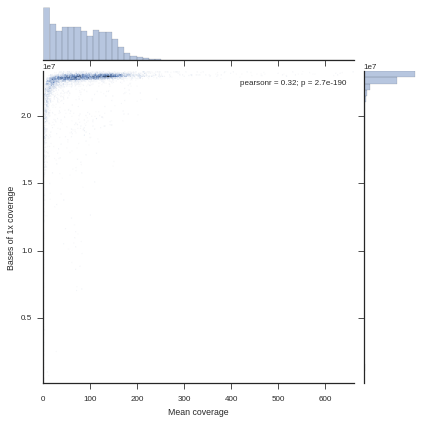

In [100]:
sns.jointplot('Mean coverage', 'Bases of 1x coverage', df, kind="hex")

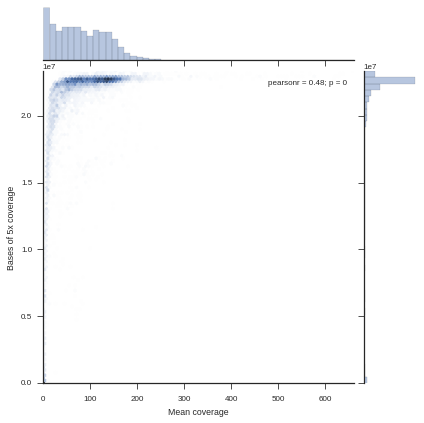

In [101]:
sns.jointplot('Mean coverage', 'Bases of 5x coverage', df, kind="hex")

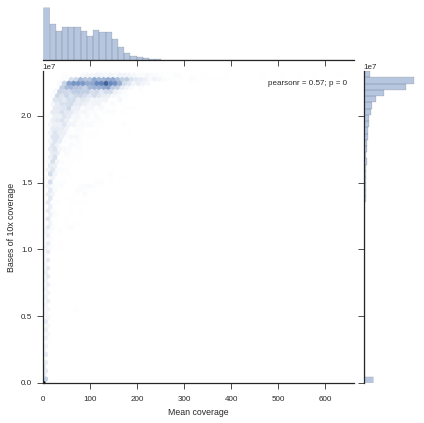

In [102]:
sns.jointplot('Mean coverage', 'Bases of 10x coverage', df, kind="hex")

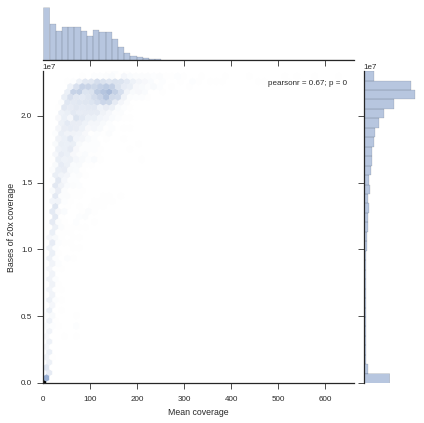

In [103]:
sns.jointplot('Mean coverage', 'Bases of 20x coverage', df, kind="hex")

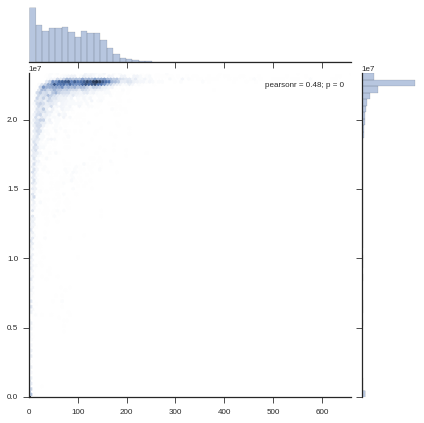

In [90]:
sns.jointplot(mean_coverage, bases_of_5X_coverage, kind="hex")

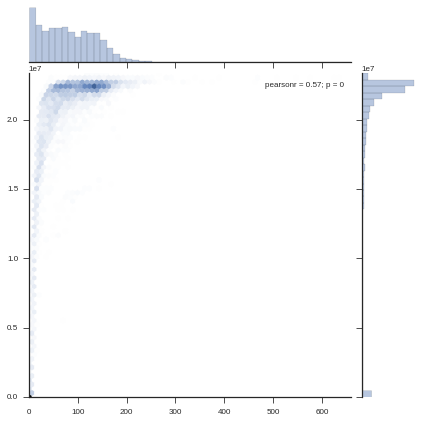

In [84]:
sns.jointplot(mean_coverage, bases_of_10X_coverage, kind="hex")

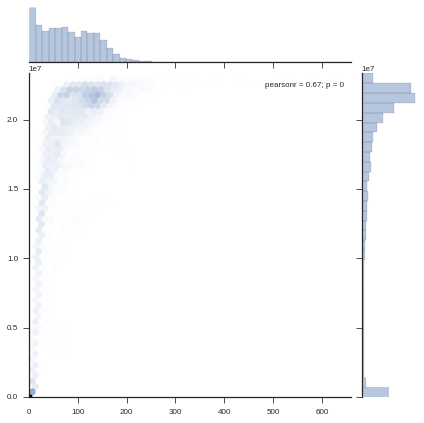

In [85]:
sns.jointplot(mean_coverage, bases_of_20X_coverage, kind="hex")

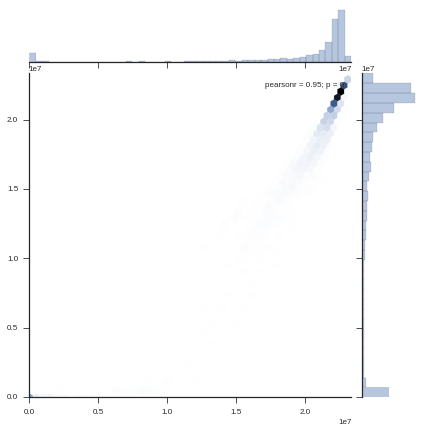

In [91]:
sns.jointplot(bases_of_10X_coverage, bases_of_20X_coverage, kind="hex")

In [58]:
bases_of_10X_coverage

array([21829039, 20463738, 19897257, ..., 19009013, 17226000, 18644748])

In [48]:
tbl_manifest.selectnotnone('orig_bases_of_5X_coverage')

path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number,orig_bases_of_5X_coverage,bases_of_5X_coverage,orig_mean_coverage,mean_coverage,bases_of_1X_coverage,bases_of_10X_coverage,bases_of_20X_coverage
/lustre/scratch109/malaria/pfalciparum/output/6/a/2/7/44851/1_bam_merge/pe.1.bam,PK0002-C,2BF2-068,2BF2-068,pf_community_5_0,dna,BF,BF,Burkina Faso,WAF,West Africa,1,14567400,14567400,10.41,10.41,20654084,10146957,2540346
/lustre/scratch109/malaria/pfalciparum/output/4/7/b/0/44852/1_bam_merge/pe.1.bam,PK0007-C,2BF3-033,2BF3-033,pf_community_5_0,dna,BF,BF,Burkina Faso,WAF,West Africa,1,17109459,17109459,37.53,37.53,21627470,14085893,10667771
/lustre/scratch109/malaria/pfalciparum/output/f/4/9/7/44853/1_bam_merge/pe.1.bam,PK0009-C,2BF2-070,2BF2-070,pf_community_5_0,dna,BF,BF,Burkina Faso,WAF,West Africa,1,22846119,22846119,83.60,83.60,23048029,22555177,21541966
/lustre/scratch109/malaria/pfalciparum/output/8/4/f/f/44854/1_bam_merge/pe.1.bam,PK0011-C,2BF2-060,2BF2-060,pf_community_5_0,dna,BF,BF,Burkina Faso,WAF,West Africa,1,16519228,16519228,31.69,31.69,21318571,13638129,10251449
/lustre/scratch109/malaria/pfalciparum/output/d/8/e/b/44855/1_bam_merge/pe.1.bam,PK0012-C,2BF2-058,2BF2-058,pf_community_5_0,dna,BF,BF,Burkina Faso,WAF,West Africa,1,16333158,16333158,75.64,75.64,20676664,14302894,12312316


In [50]:
tbl_manifest.select(lambda rec: rec['orig_bases_of_5X_coverage'] is not None and rec['orig_bases_of_5X_coverage'] != rec['bases_of_5X_coverage'])

path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number,orig_bases_of_5X_coverage,bases_of_5X_coverage,orig_mean_coverage,mean_coverage,bases_of_1X_coverage,bases_of_10X_coverage,bases_of_20X_coverage
/lustre/scratch109/malaria/pf_conway/output/a/d/8/6/336425/1_bam_merge/pe.1.bam,FP0030-C,KB36.14,KB36.14,conway,dna,MR,MR,Mauritania,WAF,West Africa,1,22650637,unknown,266.01,unknown,unknown,unknown,unknown


In [51]:
tbl_manifest.select(lambda rec: rec['orig_mean_coverage'] is not None and rec['orig_mean_coverage'] != rec['mean_coverage'])

path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number,orig_bases_of_5X_coverage,bases_of_5X_coverage,orig_mean_coverage,mean_coverage,bases_of_1X_coverage,bases_of_10X_coverage,bases_of_20X_coverage
/lustre/scratch109/malaria/pf_conway/output/a/d/8/6/336425/1_bam_merge/pe.1.bam,FP0030-C,KB36.14,KB36.14,conway,dna,MR,MR,Mauritania,WAF,West Africa,1,22650637,unknown,266.01,unknown,unknown,unknown,unknown


In [34]:
tbl_manifest.valuecounts('sub_continent').displayall()

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


sub_continent,count,frequency
WAF,2575,0.32272214563228474
ESEA,1546,0.1937586163679659
WSEA,1213,0.15202406316581024
EAF,959,0.12019050006266449
Lab,939,0.11768392029076326
CAF,374,0.0468730417345532
OCE,233,0.029201654342649454
SAS,94,0.011780924927935832
SAM,46,0.0057651334753728535


In [91]:
tbl_manifest.valuecounts('sub_continent').displayall()

sub_continent,count,frequency
WAF,2575,0.32272214563228474
ESEA,1546,0.1937586163679659
WSEA,1213,0.15202406316581024
EAF,959,0.12019050006266449
Lab,939,0.11768392029076326
CAF,374,0.0468730417345532
OCE,233,0.029201654342649454
SAS,94,0.011780924927935832
SAM,46,0.0057651334753728535


In [76]:
tbl_manifest.selectnone('sub_continent').displayall()

path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number


In [77]:
tbl_manifest.selecteq('sub_continent', 'Lab')

path,sample,oxford_src_code,oxford_donor_code,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name,sub_continent_number
/lustre/scratch109/malaria/pfalciparum/output/9/4/8/a/42798/1_bam_merge/pe.1.bam,PA0106-C,TRIPS567_0,TRIPS567,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains,9
/lustre/scratch109/malaria/pfalciparum/output/9/5/4/1/42799/1_bam_merge/pe.1.bam,PA0106-CW,TRIPS567_30,TRIPS567,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains,9
/lustre/scratch109/malaria/pfalciparum/output/e/7/c/6/42800/1_bam_merge/pe.1.bam,PA0106-CW2,TRIPS567_41,TRIPS567,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains,9
/lustre/scratch109/malaria/pfalciparum/output/4/5/3/e/42801/1_bam_merge/pe.1.bam,PA0106-CW3,TRIPS567_48,TRIPS567,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains,9
/lustre/scratch109/malaria/pfalciparum/output/a/f/1/d/42802/1_bam_merge/pe.1.bam,PA0107-C,TRIPS546_0,TRIPS546,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains,9


In [78]:
len(tbl_all_bams.leftjoin(tbl_solaris, lkey='sample', rkey='oxford_code').data())

8068

In [92]:
manifest_fn

'/nfs/team112_internal/rp7/data/Pf/hrp/metadata/hrp_manifest_20160621.txt'

In [93]:
tbl_manifest.totsv(manifest_fn)

In [96]:
tbl_manifest.selectne('dataset', 'pf3k_pilot_5_0_broad').cut(['path', 'sample']).totsv(jim_manifest_fn)

In [293]:
manifest_fn

'/nfs/team112_internal/rp7/data/Pf/hrp/metadata/hrp_manifest.txt'

In [291]:
len(tbl_manifest.data())

7979

In [95]:
len(tbl_manifest.selectne('dataset', 'pf3k_pilot_5_0_broad').cut(['path', 'sample']).data())

7842

In [292]:
len(tbl_manifest.distinct('sample').data())

7979

In [267]:
tbl_temp = tbl_manifest.addfield('bam_exists', lambda rec: os.path.exists(rec['path']))
tbl_temp.valuecounts('bam_exists')

bam_exists,count,frequency
True,8332,1.0


In [299]:
with open(lookseq_fn, "w") as fo:
    for rec in tbl_manifest:
        bam_fn = rec[0]
        sample_name = "%s_%s" % (rec[1].replace('-', '_'), rec[3])
        group_name = "%s %s %s %s" % (rec[9], rec[7], rec[6], rec[4])
        print(
            '"%s" : { "bam":"%s", "species" : "pf_3d7_v3" , "alg" : "bwa" , "group" : "%s" } ,' % (sample_name, bam_fn, group_name),
            file=fo
        )
# "PG0049_CW2" : { "bam":"/lustre/scratch109/malaria/pfalciparum/output/e/b/8/6/144292/1_bam_merge/pe.1.bam" , "species" : "pf_3d7_v3" , "alg" : "bwa" , "group" : "1104-PF-LAB-WENDLER" } ,


In [ ]:
2+2

In [262]:
tbl_manifest

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


path,sample,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name
/lustre/scratch109/malaria/pfalciparum/output/a/1/d/0/265637/1_bam_merge/pe.1.bam,QT0001-C,pf_community_5_1,dna,BJ,BJ,Benin,WAF,West Africa
/lustre/scratch109/malaria/pfalciparum/output/f/1/2/c/265638/1_bam_merge/pe.1.bam,QT0001-CW4,pf_community_5_1,MDA,BJ,BJ,Benin,WAF,West Africa
/lustre/scratch109/malaria/pfalciparum/output/0/2/0/6/265639/1_bam_merge/pe.1.bam,QT0001-CW5,pf_community_5_1,MDA,BJ,BJ,Benin,WAF,West Africa
/lustre/scratch109/malaria/pfalciparum/output/d/a/a/f/265640/1_bam_merge/pe.1.bam,QT0001-CW6,pf_community_5_1,MDA,BJ,BJ,Benin,WAF,West Africa
/lustre/scratch109/malaria/pfalciparum/output/6/7/b/4/265641/1_bam_merge/pe.1.bam,QT0002-C,pf_community_5_1,dna,BJ,BJ,Benin,WAF,West Africa


In [263]:
tbl_manifest.tail(5)

path,sample,dataset,type,region_code,country_code,country_name,sub_continent,sub_continent_name
/lustre/scratch109/malaria/pfalciparum/output/e/b/4/1/248663/1_bam_merge/pe.1.bam,WS0082-C,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains
/lustre/scratch109/malaria/pfalciparum/output/8/9/f/a/248664/1_bam_merge/pe.1.bam,WS0083-C,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains
/lustre/scratch109/malaria/pfalciparum/output/b/7/a/3/248665/1_bam_merge/pe.1.bam,WS0084-C,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains
/lustre/scratch109/malaria/pfalciparum/output/7/e/e/f/248666/1_bam_merge/pe.1.bam,WS0085-C,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains
/lustre/scratch109/malaria/pfalciparum/output/6/f/9/a/248667/1_bam_merge/pe.1.bam,WS0086-C,pf_community_5_1,dna,Lab,Lab,None,Lab,Lab strains


In [216]:
tbl_manifest.select(lambda rec: rec['sample'].startswith('QZ')).displayall()

path,sample,dataset,type,solaris_country,solaris_country_code,v4_region,v5_region,region,code_from_country,region_code,country_from_region,country_code,country_name,sub_continent,sub_continent_number,sub_continent_name


In [215]:
tbl_manifest.selecteq('sample', 'WL0071-C').displayall()

path,sample,dataset,type,solaris_country,solaris_country_code,v4_region,v5_region,region,code_from_country,region_code,country_from_region,country_code,country_name,sub_continent,sub_continent_number,sub_continent_name
/lustre/scratch109/malaria/pfalciparum/output/1/b/7/a/248639/1_bam_merge/pe.1.bam,WL0071-C,pf_community_5_1,dna,Cambodia,NULL,None,None,Cambodia,KH,KH,None,KH,Cambodia,ESEA,5,Eastern south-east Asia


In [214]:
tbl_manifest.selecteq('country_code', 'UK').displayall()

path,sample,dataset,type,solaris_country,solaris_country_code,v4_region,v5_region,region,code_from_country,region_code,country_from_region,country_code,country_name,sub_continent,sub_continent_number,sub_continent_name
/lustre/scratch109/malaria/pfalciparum/output/a/f/5/a/43327/1_bam_merge/pe.1.bam,PF0001-C,pf_community_5_0,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/d/a/4/1/108707/1_bam_merge/pe.1.bam,WH0001-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/e/3/3/7/108708/1_bam_merge/pe.1.bam,WH0002-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/2/4/1/3/108709/1_bam_merge/pe.1.bam,WH0003-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/1/3/0/e/108710/1_bam_merge/pe.1.bam,WH0004-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/4/3/6/c/108711/1_bam_merge/pe.1.bam,WH0005-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/d/5/5/8/108712/1_bam_merge/pe.1.bam,WH0006-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/f/2/6/3/108713/1_bam_merge/pe.1.bam,WH0007-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/6/6/7/e/108714/1_bam_merge/pe.1.bam,WH0008-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None
/lustre/scratch109/malaria/pfalciparum/output/1/6/6/2/108715/1_bam_merge/pe.1.bam,WH0009-C,pf_community_5_1,dna,United Kingdom,NULL,-,None,United Kingdom,UK,UK,None,UK,None,None,None,None


In [97]:
tbl_manifest.valuecounts('type', 'dataset').displayall()

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


type,dataset,count,frequency
dna,pf_community_5_0,6255,0.7427858924118276
dna,pf_community_5_1,1159,0.13763211020068875
dna,pdna,286,0.03396271226695167
MDA,pf_community_5_0,170,0.020187626172663578
unknown,pf3k_pilot_5_0_broad,137,0.016268851680323004
dna,trac,105,0.012468827930174564
unknown,pdna,89,0.010568816055100344
dna,conway,86,0.010212563828523927
dna,fanello,84,0.00997506234413965
MDA,pf_community_5_1,48,0.0057000356252226575


In [133]:
lkp_country_code = etl.lookup(tbl_country_code, 'code', 'country')

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


In [98]:
tbl_manifest.selecteq('type', 'unknown').selecteq('dataset', 'pf_community_5_1')

path,sample,dataset,type,v4_region,v5_region,region
/lustre/scratch109/malaria/pfalciparum/output/c/3/4/6/265563/1_bam_merge/pe.1.bam,PJ0128-C,pf_community_5_1,unknown,None,None,None


In [100]:
tbl_manifest.select(lambda rec: rec['v4_region'] is not None and rec['v5_region'] is not None and rec['v4_region'] != rec['v5_region'])

path,sample,dataset,type,v4_region,v5_region,region


In [101]:
tbl_manifest.select(lambda rec: rec['v4_region'] is not None and rec['v5_region'] is not None)

path,sample,dataset,type,v4_region,v5_region,region
/lustre/scratch109/malaria/pfalciparum/output/8/0/a/3/43045/1_bam_merge/pe.1.bam,PD0003-C,pf_community_5_0,dna,WTH,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/a/e/1/1/43046/1_bam_merge/pe.1.bam,PD0004-03,pf_community_5_0,dna,WTH,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/e/0/f/a/43047/1_bam_merge/pe.1.bam,PD0004-C,pf_community_5_0,dna,WTH,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/3/c/6/1/43048/1_bam_merge/pe.1.bam,PD0005-01,pf_community_5_0,dna,WTH,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/7/c/2/a/43049/1_bam_merge/pe.1.bam,PD0005-C,pf_community_5_0,dna,WTH,WTH,WTH


In [102]:
tbl_manifest.select(lambda rec: rec['v4_region'] is None and rec['v5_region'] is not None)

path,sample,dataset,type,v4_region,v5_region,region
/lustre/scratch109/malaria/pfalciparum/output/3/9/c/e/247418/1_bam_merge/pe.1.bam,PD1476-C,pf_community_5_0,dna,None,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/3/1/9/9/247421/1_bam_merge/pe.1.bam,PD1480-C,pf_community_5_0,dna,None,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/8/3/d/a/247431/1_bam_merge/pe.1.bam,PD1493-C,pf_community_5_0,dna,None,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/2/4/f/7/247432/1_bam_merge/pe.1.bam,PD1494-C,pf_community_5_0,dna,None,WTH,WTH
/lustre/scratch109/malaria/pfalciparum/output/4/c/b/9/247444/1_bam_merge/pe.1.bam,PD1510-C,pf_community_5_0,dna,None,WTH,WTH


In [103]:
tbl_manifest.select(lambda rec: rec['v4_region'] is not None and rec['v5_region'] is None)

path,sample,dataset,type,v4_region,v5_region,region
/lustre/scratch109/malaria/pfalciparum/output/2/d/d/a/42721/1_bam_merge/pe.1.bam,PA0007-C,pf_community_5_0,dna,GM,None,None
/lustre/scratch109/malaria/pfalciparum/output/0/2/f/9/42722/1_bam_merge/pe.1.bam,PA0008-C,pf_community_5_0,dna,GM,None,None
/lustre/scratch109/malaria/pfalciparum/output/3/d/9/5/42723/1_bam_merge/pe.1.bam,PA0011-C,pf_community_5_0,dna,GM,None,None
/lustre/scratch109/malaria/pfalciparum/output/5/6/7/1/42724/1_bam_merge/pe.1.bam,PA0012-C,pf_community_5_0,dna,GM,None,None
/lustre/scratch109/malaria/pfalciparum/output/b/a/0/5/42725/1_bam_merge/pe.1.bam,PA0013-C,pf_community_5_0,dna,GM,None,None


In [135]:
lkp_code_country = etl.lookup(tbl_country_code, 'country', 'code')

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


In [136]:
lkp_country_code['BZ']

KeyError: 'BZ'

In [125]:
tbl_manifest.valuecounts('region').displayall()

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


region,count,frequency
WTH,936,0.11115069469184183
GH,783,0.0929818311364446
WKH,705,0.08371927324545779
Lab,634,0.07528797054981594
Tanzania,558,0.06626291414321339
MW,369,0.04381902386889918
Mali,354,0.0420377627360171
CD,290,0.03443771523572022
VN,264,0.031350195938724616
unknown,230,0.0273126707041919


In [126]:
tbl_manifest.selecteq('region', 'unknown').valuecounts('dataset').displayall()

dataset,count,frequency
pf3k_pilot_5_0_broad,137,0.5956521739130435
pdna,89,0.3869565217391304
pf_community_5_1,4,0.017391304347826087


In [177]:
tbl_manifest.valuecounts('region_code').displayall()

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


region_code,count,frequency
WTH,936,0.11115069469184183
GH,884,0.10497565609785062
WKH,705,0.08371927324545779
Lab,634,0.07528797054981594
TZ,629,0.07469421683885524
ML,455,0.05403158769742311
CD,374,0.044412777579859876
MW,369,0.04381902386889918
GM,287,0.03408146300914381
VN,265,0.03146894668091676


In [178]:
tbl_manifest.selecteq('region_code', 'unknown').valuecounts('dataset').displayall()

dataset,count,frequency
pdna,89,0.956989247311828
pf_community_5_1,4,0.043010752688172046


In [179]:
tbl_manifest.valuecounts('country_code').displayall()

country_code,count,frequency
KH,1207,0.14333214582591142
TH,991,0.11768198551240945
GH,884,0.10497565609785062
Lab,634,0.07528797054981594
TZ,629,0.07469421683885524
ML,455,0.05403158769742311
CD,374,0.044412777579859876
MW,369,0.04381902386889918
GM,287,0.03408146300914381
VN,265,0.03146894668091676


In [180]:
tbl_manifest.selecteq('country_code', 'unknown').valuecounts('dataset').displayall()

dataset,count,frequency
pdna,89,0.956989247311828
pf_community_5_1,4,0.043010752688172046


In [191]:
tbl_manifest.valuecounts('country_name').displayall()

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


country_name,count,frequency
Cambodia,1207,0.14333214582591142
Thailand,991,0.11768198551240945
None,904,0.10735067094169339
Ghana,884,0.10497565609785062
"Tanzania, United Republic of",629,0.07469421683885524
Mali,455,0.05403158769742311
"Congo, the Democratic Republic of the",374,0.044412777579859876
Malawi,369,0.04381902386889918
Gambia,287,0.03408146300914381
Viet Nam,265,0.03146894668091676


In [200]:
tbl_manifest.valuecounts('region_code', 'country_name').toxlsx(regions_in_dataset_fn)

In [205]:
tbl_manifest.valuecounts('sub_continent').displayall()

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


sub_continent,count,frequency
WAF,2672,0.3173019831373946
ESEA,1913,0.22717016981356133
EAF,1239,0.14713216957605985
WSEA,931,0.11055694098088113
None,904,0.10735067094169339
CAF,374,0.044412777579859876
OCE,232,0.02755017218857618
SAS,94,0.011162569766061038
SAM,62,0.0073625460159125996


In [207]:
tbl_manifest.cut(['path', 'sample', 'dataset', 'type', 'region_code', 'country_code', 'country_name', 'sub_continent'])

path,sample,dataset,type,region_code,country_code,country_name,sub_continent
/lustre/scratch109/malaria/pfalciparum/output/a/8/9/3/45092/1_bam_merge/pe.1.bam,PR0001-CW,pf_community_5_0,MDA,BD,BD,Bangladesh,SAS
/lustre/scratch109/malaria/pfalciparum/output/9/0/6/7/45093/1_bam_merge/pe.1.bam,PR0002-CW,pf_community_5_0,MDA,BD,BD,Bangladesh,SAS
/lustre/scratch109/malaria/pfalciparum/output/e/6/0/d/45094/1_bam_merge/pe.1.bam,PR0003-CW,pf_community_5_0,MDA,BD,BD,Bangladesh,SAS
/lustre/scratch109/malaria/pfalciparum/output/0/4/c/5/45095/1_bam_merge/pe.1.bam,PR0004-CW,pf_community_5_0,MDA,BD,BD,Bangladesh,SAS
/lustre/scratch109/malaria/pfalciparum/output/f/8/f/1/45096/1_bam_merge/pe.1.bam,PR0005-CW,pf_community_5_0,MDA,BD,BD,Bangladesh,SAS
